In [1]:
import logging, sys
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA 
from IPython.display import display, Latex
from mpl_toolkits.mplot3d import Axes3D

from randnn import downsample, downsample_split, avg_over
from randnn.utils import np_cache, eigsort
from randnn.plotting import *
from randnn.systems import Lorenz
from randnn.transfer_operator import *

rc('text', usetex=True)
#logging.basicConfig(level=logging.INFO)
np.set_printoptions(threshold=100)

# Applying the transfer operator approach

### 1. Coarse-graining in space:

#### Clustering

We run an explicit coarse-graining step by clustering the embedding space.

### 2. Coarse-graining in time: 

#### Downsampling
We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory, discarding many intermediate timesteps.

#### Delay embedding
To achieve a near-memory-less (Markovian) definition of state, we stack delayed copies of measurements within a short time window.

# Parameters

In [2]:
# ------------------------
# DOUBLE WELL PARAMETERS
# ------------------------

# Main parameters:
SIGMA=10.
RHO=28
BETA=8. / 3

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.01 # 0.01 
DOWNSAMPLE_RATE = 10 # 10

TIMESPAN = 1000 # 100000
N_STEPS = int(TIMESPAN // TIMESTEP)
N_BURN_IN = 1000 

N_CLUSTERS = 500
TRANSITION_TIMESCALE = 1 # This is the number of timesteps to take before counting a transition from one cell to the next
# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

Generating samples: 100%|██████████| 99999/99999 [00:30<00:00, 3256.92it/s]
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/lorenz.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  forward_entropies[i] = matrix.forward_entropy
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/lorenz.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  reverse_entropies[i] = matrix.reverse_entropy
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/lorenz.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  entropy_productions[i] = matrix.entropy_production
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/lorenz.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  forward_entropies[i] = matrix.forward_entropy
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/lorenz.py:68: ComplexWarning: Casting complex 

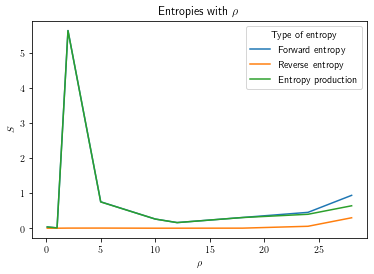

In [3]:
RATE = 1
TIMESTEP = 0.01
RHOS = [ 0.1, 1, 2, 5, 10, 12, 18, 24, 28]
TIMESTEP = 0.01
plot_lorenz_entropies_with_rhos(RHOS, RATE, TIMESTEP, N_STEPS, N_BURN_IN, N_CLUSTERS)

# Generating data

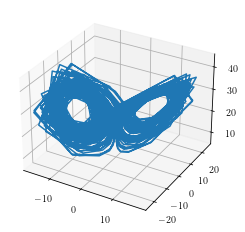

In [4]:
lorenz = Lorenz(sigma=SIGMA, rho=RHO, beta=BETA, timestep=TIMESTEP)
time_series = lorenz.run(n_steps=N_STEPS, n_burn_in=N_BURN_IN)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE, k=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(time_series[:1000,0],time_series[:1000,1],time_series[:1000,2])

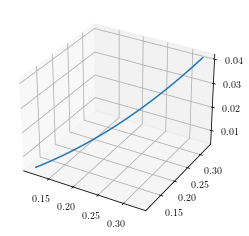

In [5]:
lorenz = Lorenz(sigma=SIGMA, rho=1, beta=BETA, timestep=TIMESTEP)
time_series = lorenz.run(n_steps=N_STEPS, n_burn_in=N_BURN_IN)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE, k=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(time_series[:1000,0],time_series[:1000,1],time_series[:1000,2])

/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/transfer_operator.py:123: ConvergenceWarning: Number of distinct clusters (262) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  self.labeler.fit(time_series)


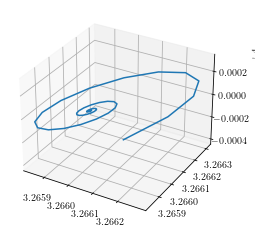

In [6]:
lorenz = Lorenz(sigma=SIGMA, rho=5, beta=BETA, timestep=TIMESTEP)
time_series = lorenz.run(n_steps=N_STEPS, n_burn_in=N_BURN_IN)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE, k=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(time_series[:1000,0],time_series[:1000,1],time_series[:1000,2])

/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/transfer_operator.py:123: ConvergenceWarning: Number of distinct clusters (467) found smaller than n_clusters (500). Possibly due to duplicate points in X.
  self.labeler.fit(time_series)


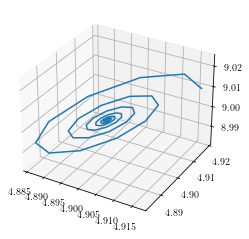

In [7]:
lorenz = Lorenz(sigma=SIGMA, rho=10, beta=BETA, timestep=TIMESTEP)
time_series = lorenz.run(n_steps=N_STEPS, n_burn_in=N_BURN_IN)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="kmeans", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE, k=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(time_series[:1000,0],time_series[:1000,1],time_series[:1000,2])

## Equilibrium

Let's establish that we've actually settled into equilibrium. 

### Boltzmann distribution

The first check is that the Boltzmann distributions appear qualitatively similar. If this is off, we already know we need to go back to the drawing board.


XY


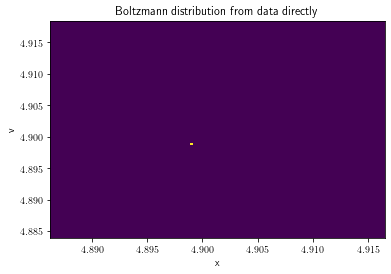

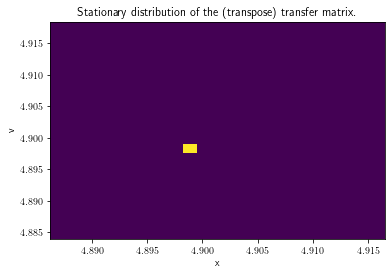

In [8]:
print("XY")
N_BINS = 50

dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T

# We compare the Boltzmann distribution directly from data...

plt.hist2d(time_series[:, 0], time_series[:, 1], bins=N_BINS*2)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Boltzmann distribution from data directly")
plt.show()

# ...with the distribution from the transfer matrix...

cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

stable_dist = np.abs(eigvecs[:,0])/ np.sum(np.abs(eigvecs[:, 0]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 0], cluster_centers[:, 1], bins=N_BINS//2, weights=stable_dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Stationary distribution of the (transpose) transfer matrix.")
plt.show()



YZ


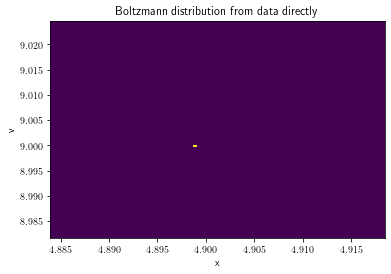

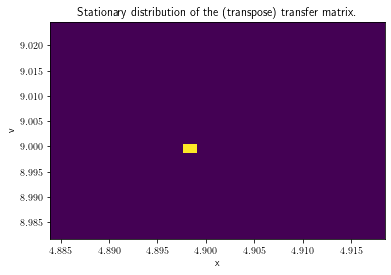

In [9]:
print("YZ")
N_BINS = 50

dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T

# We compare the Boltzmann distribution directly from data...

plt.hist2d(time_series[:, 1], time_series[:, 2], bins=N_BINS*2)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Boltzmann distribution from data directly")
plt.show()

# ...with the distribution from the transfer matrix...

cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

stable_dist = np.abs(eigvecs[:,0])/ np.sum(np.abs(eigvecs[:, 0]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 1], cluster_centers[:, 2], bins=N_BINS//2, weights=stable_dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Stationary distribution of the (transpose) transfer matrix.")
plt.show()



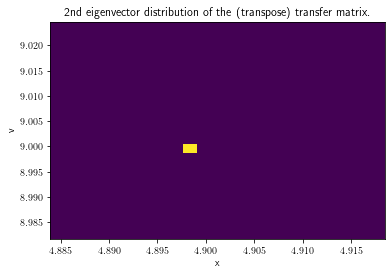

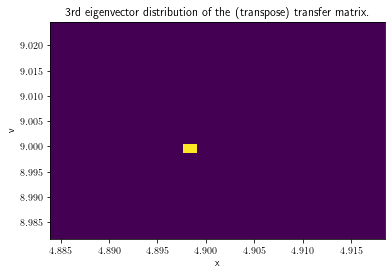

In [10]:
cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

dist = np.abs(eigvecs[:,1])/ np.sum(np.abs(eigvecs[:, 1]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 1], cluster_centers[:, 2], bins=N_BINS//2, weights=dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("2nd eigenvector distribution of the (transpose) transfer matrix.")
plt.show()

cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")

dist = np.abs(eigvecs[:,2])/ np.sum(np.abs(eigvecs[:, 2]))
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist2d(cluster_centers[:, 1], cluster_centers[:, 2], bins=N_BINS//2, weights=dist)
plt.xlabel("x")
plt.ylabel("v")
plt.title("3rd eigenvector distribution of the (transpose) transfer matrix.")
plt.show()

### Convergence

We make sure we've included enough burn in samples and that the running average energy isn't fluctuating too wildly.

### Eigenvalue spectrum & Timescale separation

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


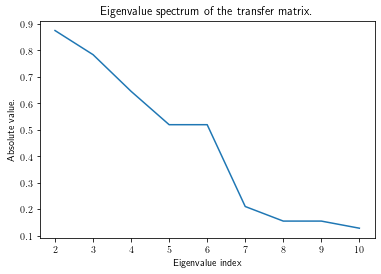

In [11]:
plot_eig_spectrum(eigvals, EIGENVALUE_RANGE, "Eigenvalue spectrum of the transfer matrix.")

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python

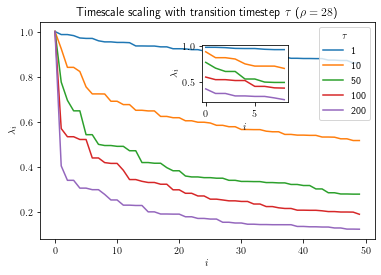

In [12]:
RATES = [1, 10, 50, 100, 200]
plot_lorenz_spectra_with_rates(RATES, TIMESTEP, N_STEPS, N_BURN_IN, N_CLUSTERS)

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python

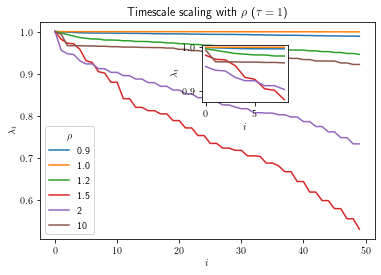

In [13]:
RHOS = [ 0.9, 1.0, 1.2, 1.5, 2, 10]
plot_lorenz_spectra_with_rhos(RHOS, TIMESTEP, N_STEPS, N_BURN_IN, N_CLUSTERS)

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python

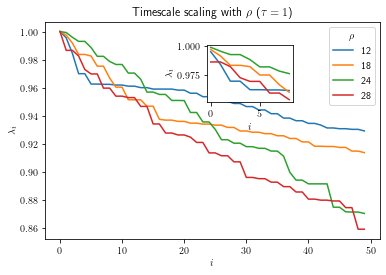

In [14]:
RHOS = [ 12, 18, 24, 28]
plot_lorenz_spectra_with_rhos(RHOS, TIMESTEP, N_STEPS, N_BURN_IN, N_CLUSTERS)

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python

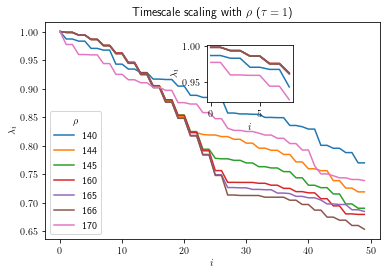

In [15]:
RHOS = [ 140, 144, 145, 160, 165, 166, 170]
plot_lorenz_spectra_with_rhos(RHOS, TIMESTEP, N_STEPS, N_BURN_IN, N_CLUSTERS)

# Timescale convergence

computing `t_imp` for `n_clusters = 9`: 5it [00:00,  5.74it/s]
computing `t_imp` for `n_clusters = 100`: 5it [00:07,  1.40s/it]
computing `t_imp` for `n_clusters = 400`: 0it [00:12, ?it/s]


ArpackNoConvergence: ARPACK error -1: No convergence (4001 iterations, 1/2 eigenvectors converged)

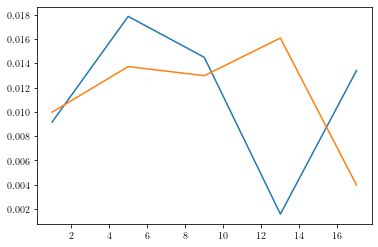

In [16]:
N_CLUSTERS_LIST = [9, 100, 400]
TRANSITION_TIMES = range(1, 20, 4)

plot_t_imp_scaling(time_series, 
                   1, 
                   n_clusters_list=N_CLUSTERS_LIST, 
                   transition_times=TRANSITION_TIMES,
                   timestep=TIMESTEP/DOWNSAMPLE_RATE)